In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# This makes plots show up and look nice
#matplotlib inline
sns.set(context='paper',style='white',font_scale=1.5,rc={"lines.linewidth":2.5})
sns.set_palette('muted')

# Hodgkin and Huxley model 
Modified from **modeling neural circuits made simple with Python**

The 4 differential equations that govern the whole model

\begin{align*}
C_m \frac{{dV}}{{dt}} &= Ix(t) - \bar{g}_{\text{Na}}m^3h(V - E_{\text{Na}}) - \bar{g}_{\text{K}}n^4(V - E_{\text{K}}) - \bar{g}_{\text{L}}(V - E_{\text{L}}) \\
\frac{{dn}}{{dt}} &= \alpha_n(V)(1 - n) - \beta_n(V)n \\
\frac{{dh}}{{dt}} &= \alpha_h(V)(1 - h) - \beta_h(V)h \\
\frac{{dm}}{{dt}} &= \alpha_m(V)(1 - m) - \beta_m(V)m \\
\end{align*}

- m causes V to increase
- h stops V from increasing (inactivates gNa)
- n causes V to decrease (activates Kv)



In [16]:
# Discretized time
T=30 #ms
dt=.001
time=np.arange(0,T,dt)

# Initialize applied current
Ix=np.zeros_like(time)
#print(Ix)
#print(len(Ix))


# Add smooth step input
from scipy.stats import norm
StepStrength=20 #picoAmps
StepTime=13
StepWidth=1

Ix=Ix+StepStrength*norm.cdf(time,StepTime,StepWidth)



Kinetic parameters are given by:

\begin{align*}
\alpha_n(V) &= \frac{{0.01(V + 55)}}{{1 - \exp(-0.1(V + 55))}} \\
\beta_n(V) &= 0.125\exp\left(-\frac{{0.0125(V + 65)}}{{0.1}}\right) \\
\alpha_m(V) &= \frac{{0.1(V + 40)}}{{1 - \exp(-0.1(V + 40))}} \\
\beta_m(V) &= 4\exp\left(-\frac{{(V + 65)}}{{18}}\right) \\
\alpha_h(V) &= 0.07\exp\left(-\frac{{(V + 65)}}{{20}}\right) \\
\beta_h(V) &= \frac{{1}}{{1 + \exp(-0.1(V + 35))}}
\end{align*}

Values are: 

Cm = 1μF/cm2, gL = 0.3 mS/cm2,
EL = −54.387, gK = 36 mS/cm2, EK = −77 mV, gNa = 120 mS/cm2, ENa = 50 mV,
Ix(t) injected by symphony



In [17]:
# Define gating variables 
alphan = lambda V: .01*(V+55)/(1-np.exp(-.1*(V+55)))
betan = lambda V: .125*np.exp(-.0125*(V+65))
alpham = lambda V: .1*(V+40)/(1-np.exp(-.1*(V+40)))
betam = lambda V: 4*np.exp(-.0556*(V+65))
alphah = lambda V: .07*np.exp(-.05*(V+65))
betah = lambda V: 1/(1+np.exp(-.1*(V+35)))


# n variable
ninfty= lambda V: (alphan(V)/(alphan(V)+betan(V)))
taun= lambda V: (1/(alphan(V)+betan(V)))
minfty= lambda V: (alpham(V)/(alpham(V)+betam(V)))
taum= lambda V: (1/(alpham(V)+betam(V)))
hinfty= lambda V: (alphah(V)/(alphah(V)+betah(V)))
tauh= lambda V: (1/(alphah(V)+betah(V)))

# Parameters
Cm=1
gL=.3
EL=-54.387
gK=36
EK=-77
gNa=120
ENa=50


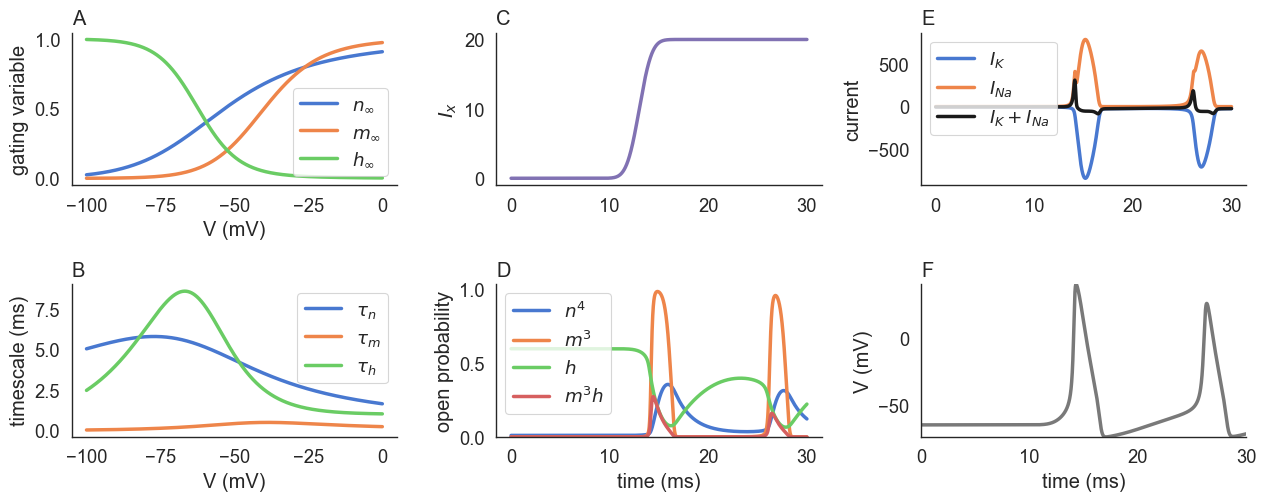

In [18]:

# Initial conditions near their fixed points when Ix=0
V0=-65.0
n0=ninfty(V0)
m0=minfty(V0)
h0=hinfty(V0)


# Currents
IL= lambda V: (-gL*(V-EL))
IK = lambda n,V: (-gK*n **4*(V-EK))
INa = lambda m,h,V: (-gNa*m **3*h*(V-ENa))

# Toal ion currents
Iion = lambda n,m,h,V: IL(V)+IK(n,V)+INa(m,h,V)

# Forward Euler method
V=np.zeros_like(time)
n=np.zeros_like(time)
m=np.zeros_like(time)
h=np.zeros_like(time)
V[0]=V0
n[0]=n0
m[0]=m0
h[0]=h0
for i in range(len(time)-1): 
    # Update gating variables
    n[i+1]=n[i]+dt*((1-n[i])*alphan(V[i])-n[i]*betan(V[i]))
    m[i+1]=m[i]+dt*((1-m[i])*alpham(V[i])-m[i]*betam(V[i]))
    h[i+1]=h[i]+dt*((1-h[i])*alphah(V[i])-h[i]*betah(V[i]))

    # Update membrane potential
    V[i+1]=V[i]+dt*(Iion(n[i],m[i],h[i],V[i])+Ix[i])/Cm



In [ ]:

# Make figure
plt.subplots(2,3,figsize=(13,5.25))


# Membrane potential for plotting
Vplot=np.arange(-100,0,.1)

plt.subplot(2,3,1)
plt.plot(Vplot,ninfty(Vplot),label=r'$n_\infty$')
plt.plot(Vplot,minfty(Vplot),label=r'$m_\infty$')
plt.plot(Vplot,hinfty(Vplot),label=r'$h_\infty$')
plt.legend()
plt.xlabel('V (mV)')
plt.ylabel('gating variable')
plt.title('A',loc='left')
sns.despine()


plt.subplot(2,3,4)
plt.plot(Vplot,taun(Vplot),label=r'$\tau_n$')
plt.plot(Vplot,taum(Vplot),label=r'$\tau_m$')
plt.plot(Vplot,tauh(Vplot),label=r'$\tau_h$')
plt.legend()
plt.xlabel('V (mV)')
plt.ylabel('timescale (ms)')
plt.title('B',loc='left')
sns.despine()



plt.subplot(2,3,2)
plt.plot(time,Ix,'m')
plt.ylabel(r'$I_{x}$')
plt.title('C',loc='left')
sns.despine()


plt.subplot(2,3,5)
plt.plot(time,n**4,label=r'$n^4$')
plt.plot(time,m**3,label=r'$m^3$')
plt.plot(time,h,label=r'$h$')
plt.plot(time,(m**3)*h,label=r'$m^3h$')
plt.legend(loc='upper left')
plt.ylabel('open probability')
plt.xlabel('time (ms)')
plt.ylim(bottom=0)
plt.title('D',loc='left')
sns.despine()

plt.subplot(2,3,3)
plt.plot(time,IK(n,V),label=r'$I_K$')
plt.plot(time,INa(m,h,V),label=r'$I_{Na}$')
plt.plot(time,IK(n,V)+INa(m,h,V),'k',label=r'$I_K+I_{Na}$')
plt.legend(loc='upper left')
plt.ylabel('current')
plt.title('E',loc='left')
sns.despine()


plt.subplot(2,3,6)
plt.plot(time,V,color=sns.color_palette()[7])
plt.ylabel('V (mV)')
plt.xlabel('time (ms)')
plt.axis([0,T,np.min((-70,np.min(V))),np.max((-57,np.max(V)))])
plt.title('F',loc='left')
sns.despine()

plt.tight_layout()
